# Phase 1: Loading Data, Cleaning, Transformation, & Exploration

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The training data csv file was too big to upload to github, so I've uploaded the zip file containing the training and testing set files.  We'll need to extract those files from the zip so we can read them into DataFrames.

In [66]:
#with ZipFile('./Data/UNSW_NB15 training and testing sets.zip') as datasets_zip:
#    # open each file and read in to a DataFrame
#    with datasets_zip.open('UNSW_NB15_training-set.csv') as training_file:
#        training_data = pd.read_csv(training_file)
#    with datasets_zip.open('UNSW_NB15_testing-set.csv') as testing_file:
#        testing_data = pd.read_csv(testing_file)

In [2]:
training_file = './data/UNSW_NB15_training-set.csv'
training_data = pd.read_csv(training_file)
print(training_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

OK, it looks like we've got 175,341 entries and no null values in any column.
There are 44 columns, but I think there should be a few more, so let's investigate that in a minute.

For training the ML models, we'll want to separate the class labels from the rest of the data.  But for investigating correlations, we'll want to include the labels.

I might want to think about renaming these columns to something more readable.

In [3]:
training_data.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


Here we can see that the 4 object type features (proto, service, state, and attack_cat) appear to be Strings.
attack_cat is the class to be learned, might want to convert that to an integer. Label is either 0 or 1, indicating benign or malicious.

Let's see how many classes there are.

In [4]:
print("There are", training_data['attack_cat'].nunique(), "unique values.")
print("Categories:", training_data['attack_cat'].unique())

There are 10 unique values.
Categories: ['Normal' 'Backdoor' 'Analysis' 'Fuzzers' 'Shellcode' 'Reconnaissance'
 'Exploits' 'DoS' 'Worms' 'Generic']


OK, it looks like 9 classes of Malware, plus 'Normal' benign activity.
Maybe we can convert the classes to category type and order them so we can look for correlations with other features.  Or we can just convert them to an integer sequence instead.

In [5]:
training_data['attack_cat'] = training_data['attack_cat'].astype('category')
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   id                 175341 non-null  int64   
 1   dur                175341 non-null  float64 
 2   proto              175341 non-null  object  
 3   service            175341 non-null  object  
 4   state              175341 non-null  object  
 5   spkts              175341 non-null  int64   
 6   dpkts              175341 non-null  int64   
 7   sbytes             175341 non-null  int64   
 8   dbytes             175341 non-null  int64   
 9   rate               175341 non-null  float64 
 10  sttl               175341 non-null  int64   
 11  dttl               175341 non-null  int64   
 12  sload              175341 non-null  float64 
 13  dload              175341 non-null  float64 
 14  sloss              175341 non-null  int64   
 15  dloss              175341 non-null

Let's see what those other objects are all about.

In [6]:
print("There are", training_data['proto'].nunique(), "unique values.")
print("Protocols:", training_data['proto'].unique())

There are 133 unique values.
Protocols: ['tcp' 'udp' 'arp' 'ospf' 'icmp' 'igmp' 'rtp' 'ddp' 'ipv6-frag' 'cftp'
 'wsn' 'pvp' 'wb-expak' 'mtp' 'pri-enc' 'sat-mon' 'cphb' 'sun-nd' 'iso-ip'
 'xtp' 'il' 'unas' 'mfe-nsp' '3pc' 'ipv6-route' 'idrp' 'bna' 'swipe'
 'kryptolan' 'cpnx' 'rsvp' 'wb-mon' 'vmtp' 'ib' 'dgp' 'eigrp' 'ax.25'
 'gmtp' 'pnni' 'sep' 'pgm' 'idpr-cmtp' 'zero' 'rvd' 'mobile' 'narp' 'fc'
 'pipe' 'ipcomp' 'ipv6-no' 'sat-expak' 'ipv6-opts' 'snp' 'ipcv'
 'br-sat-mon' 'ttp' 'tcf' 'nsfnet-igp' 'sprite-rpc' 'aes-sp3-d' 'sccopmce'
 'sctp' 'qnx' 'scps' 'etherip' 'aris' 'pim' 'compaq-peer' 'vrrp' 'iatp'
 'stp' 'l2tp' 'srp' 'sm' 'isis' 'smp' 'fire' 'ptp' 'crtp' 'sps'
 'merit-inp' 'idpr' 'skip' 'any' 'larp' 'ipip' 'micp' 'encap' 'ifmp'
 'tp++' 'a/n' 'ipv6' 'i-nlsp' 'ipx-n-ip' 'sdrp' 'tlsp' 'gre' 'mhrp' 'ddx'
 'ippc' 'visa' 'secure-vmtp' 'uti' 'vines' 'crudp' 'iplt' 'ggp' 'ip'
 'ipnip' 'st2' 'argus' 'bbn-rcc' 'egp' 'emcon' 'igp' 'nvp' 'pup' 'xnet'
 'chaos' 'mux' 'dcn' 'hmp' 'prm' 'trunk-1' 

In [7]:
print("There are", training_data['service'].nunique(), "unique values.")
print("Services:", training_data['service'].unique())

There are 13 unique values.
Services: ['-' 'ftp' 'smtp' 'snmp' 'http' 'ftp-data' 'dns' 'ssh' 'radius' 'pop3'
 'dhcp' 'ssl' 'irc']


In [8]:
print("There are", training_data['state'].nunique(), "unique values.")
print("State:", training_data['state'].unique())

There are 9 unique values.
State: ['FIN' 'INT' 'CON' 'ECO' 'REQ' 'RST' 'PAR' 'URN' 'no']


This gives us an idea of what kind of network traffic data we're working with.

Let's see the distribution of labels and classes.

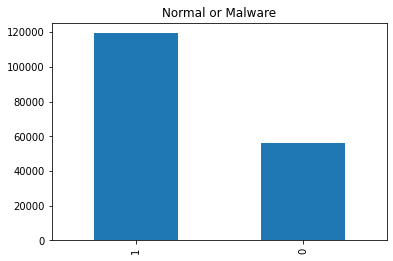

In [31]:
_ = training_data['label'].value_counts().plot(kind='bar', title='Normal or Malware')

In [13]:
training_data['label'].value_counts()

1    119341
0     56000
Name: label, dtype: int64

Here, 0 represents 'Normal' activity, and 1 is 'Malicious' activity (one of the 9 attack categories).

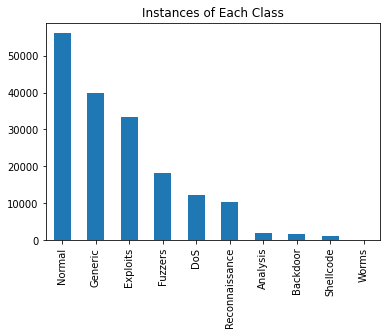

In [40]:
_ = training_data['attack_cat'].value_counts().plot(kind='bar', title='Instances of Each Class')

In [10]:
training_data['attack_cat'].value_counts()

Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: attack_cat, dtype: int64

Is there a danger of classification bias with this breakdown (only 130/175,341 instances are worms)?
What could we do to better balance without throwing away most of the data.
On the other hand this data set is probably representative of the percentages of malware in the wild.

We should calculate data correlations and plot a scatter matrix.

In [46]:
correlation_matrix = training_data.corr()

And let's see how the features correlate to the label (normal or attack).

In [48]:
correlation_matrix['label'].sort_values(ascending=False)

label                1.000000
id                   0.727173
sttl                 0.692741
ct_state_ttl         0.577704
ct_dst_sport_ltm     0.357213
rate                 0.337979
ct_src_dport_ltm     0.305579
ct_dst_src_ltm       0.303855
ct_src_ltm           0.238225
ct_dst_ltm           0.229887
ct_srv_src           0.229044
ct_srv_dst           0.228046
sload                0.182870
ackdat               0.097364
dttl                 0.095049
tcprtt               0.081584
synack               0.058299
dur                  0.036175
sbytes               0.018576
ct_flw_http_mthd     0.015800
trans_depth          0.010801
sloss               -0.000640
sjit                -0.007069
smean               -0.010798
is_ftp_login        -0.011055
ct_ftp_cmd          -0.011055
response_body_len   -0.021361
dinpkt              -0.022887
spkts               -0.052178
djit                -0.060870
dbytes              -0.076871
dloss               -0.094685
dpkts               -0.118591
sinpkt    

Scatter matrix - let's check out a scatter matrix of some of these features to better vizualize the correlation

In [64]:
attrs = ['label', 'sttl', 'ct_state_ttl'] #, 'ct_dst_sport_ltm', 'rate', 'ct_src_dport_ltm', 'ct_dst_src_ltm', 'dwin', 'swin', 'dmean', 'dload']

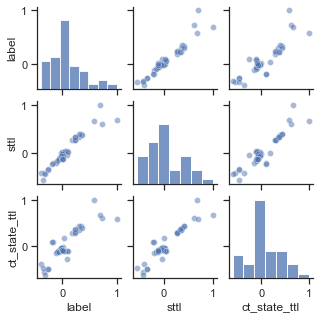

In [65]:
#training_data.plot.scatter()
#_ = scatter_matrix(correlation_matrix, figsize=(12,8))
import seaborn as sns
sns.set(style='ticks', color_codes=True)
_ = sns.pairplot(data=correlation_matrix[attrs], height=1.5, aspect=1, plot_kws={'alpha':0.5})

We can check out the statistics for each feature, do they need to be normalized?

In [26]:
feature_stats = pd.DataFrame()
for feature in training_data.columns[1:-2]:
    feature_stats = feature_stats.append(training_data[feature].describe())

In [28]:
feature_stats

,25%,50%,75%,count,max,mean,min,std,freq,top,unique
dur,0.000008,0.001582,6.680690e-01,175341.0,5.999999e+01,1.359389e+00,0.0,6.480249e+00,NaN,NaN,NaN
proto,NaN,NaN,NaN,175341.0,NaN,NaN,NaN,NaN,79946.0,tcp,133.0
service,NaN,NaN,NaN,175341.0,NaN,NaN,NaN,NaN,94168.0,-,13.0
state,NaN,NaN,NaN,175341.0,NaN,NaN,NaN,NaN,82275.0,INT,9.0
spkts,2.000000,2.000000,1.200000e+01,175341.0,9.616000e+03,2.029866e+01,1.0,1.368876e+02,NaN,NaN,NaN
dpkts,0.000000,2.000000,1.000000e+01,175341.0,1.097400e+04,1.896959e+01,0.0,1.102583e+02,NaN,NaN,NaN
sbytes,114.000000,430.000000,1.418000e+03,175341.0,1.296523e+07,8.844844e+03,28.0,1.747656e+05,NaN,NaN,NaN
dbytes,0.000000,164.000000,1.102000e+03,175341.0,1.465555e+07,1.492892e+04,0.0,1.436542e+05,NaN,NaN,NaN
rate,32.786140,3225.806520,1.250000e+05,175341.0,1.000000e+06,9.540619e+04,0.0,1.654010e+05,NaN,NaN,NaN
sttl,62.000000,254.000000,2.540000e+02,175341.0,2.550000e+02,1.795470e+02,0.0,1.029400e+02,NaN,NaN,NaN


unique, top and freq are statistics of object type features, these will go away when those features are converted to numeric.

In [29]:
feature_stats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42 entries, dur to is_sm_ips_ports
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   25%     39 non-null     float64
 1   50%     39 non-null     float64
 2   75%     39 non-null     float64
 3   count   42 non-null     float64
 4   max     39 non-null     float64
 5   mean    39 non-null     float64
 6   min     39 non-null     float64
 7   std     39 non-null     float64
 8   freq    3 non-null      float64
 9   top     3 non-null      object 
 10  unique  3 non-null      float64
dtypes: float64(10), object(1)
memory usage: 3.9+ KB


In [34]:
feature_stats.shape

(42, 11)

In [36]:
training_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,175341.0,8.767100e+04,5.061673e+04,1.0,43836.000000,87671.000000,1.315060e+05,1.753410e+05
dur,175341.0,1.359389e+00,6.480249e+00,0.0,0.000008,0.001582,6.680690e-01,5.999999e+01
spkts,175341.0,2.029866e+01,1.368876e+02,1.0,2.000000,2.000000,1.200000e+01,9.616000e+03
dpkts,175341.0,1.896959e+01,1.102583e+02,0.0,0.000000,2.000000,1.000000e+01,1.097400e+04
sbytes,175341.0,8.844844e+03,1.747656e+05,28.0,114.000000,430.000000,1.418000e+03,1.296523e+07
dbytes,175341.0,1.492892e+04,1.436542e+05,0.0,0.000000,164.000000,1.102000e+03,1.465555e+07
rate,175341.0,9.540619e+04,1.654010e+05,0.0,32.786140,3225.806520,1.250000e+05,1.000000e+06
sttl,175341.0,1.795470e+02,1.029400e+02,0.0,62.000000,254.000000,2.540000e+02,2.550000e+02
dttl,175341.0,7.960957e+01,1.105069e+02,0.0,0.000000,29.000000,2.520000e+02,2.540000e+02
sload,175341.0,7.345403e+07,1.883574e+08,0.0,13053.338870,879674.750000,8.888889e+07,5.988000e+09


The <i>id</i> feature is just a sequential numbering of the records...it's probably not necessary.  If we drop that, convert the object/categorical types to numeric and excluded the categories and labels, this is an easier way to describe the data.

Let's look at some histograms of the numeric features.

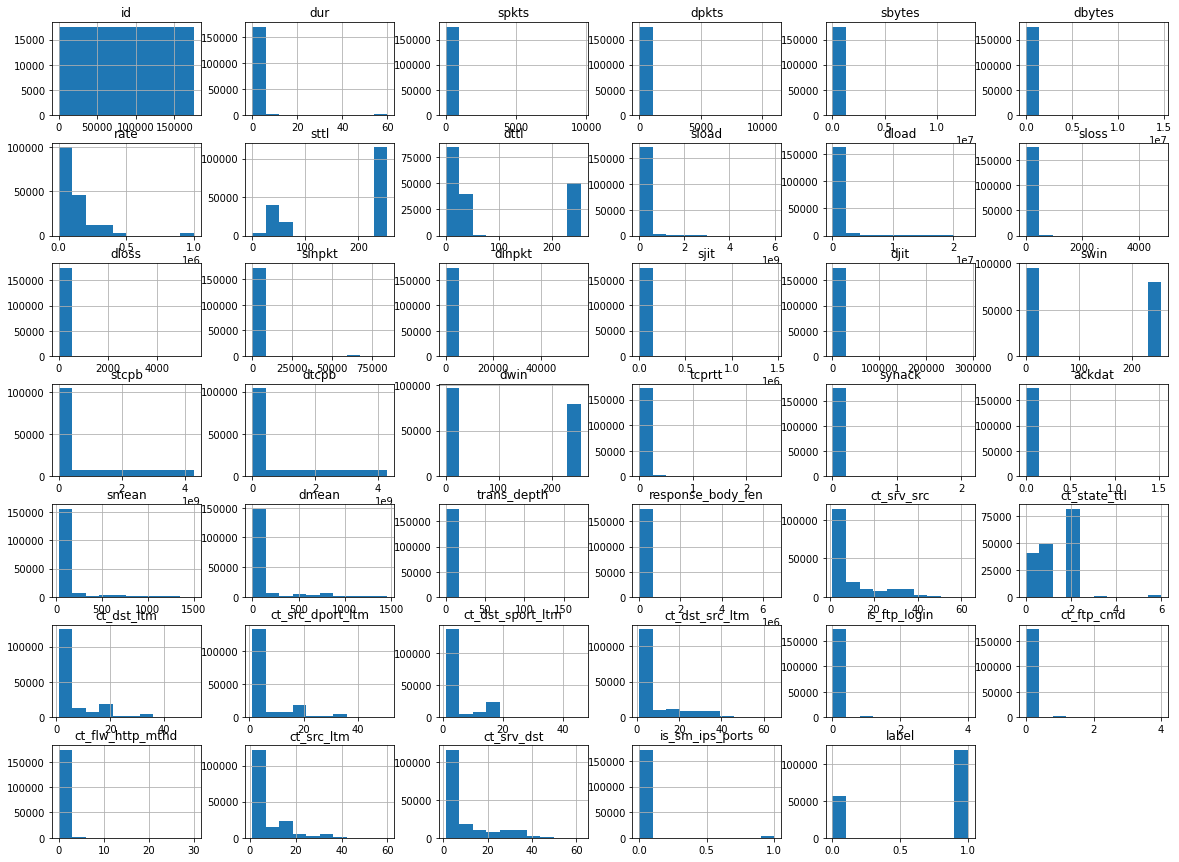

In [45]:
%matplotlib inline
training_data.hist(figsize=(20,15))
plt.show()